LOAD RELEVANT LIBRARIES

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import single, average, complete, fcluster, linkage
import re
from sklearn.cluster import AgglomerativeClustering
from collections import defaultdict
import os

INPUT SPECIES NAME (FOR LABELING)

In [98]:
species = 'E_faecalis'

READ IN DATA

In [ ]:
skani_file_path = f'/home/ubuntu/wdir/PopGenStats_Project/data/{species}/distances/skani.tsv.gz'

In [100]:
skani_matrix = pd.read_csv(skani_file_path, sep='\t')
skani_matrix['Tool'] = 'skANI'

TIDY TOOL MATRIX
- SHORTEN SAMPLE FILE NAMES
- ASSIGN SAMPLES A SIMPLIFIED SAMPLE ID
- CALCULATE ANI FOR ALIGNED BASES

In [101]:
def edit_accession_id(str):
    match = re.search(r'(GCF_|GCA_)\d{9}\.\d|flye.SQK-NBD\d{3}-\d{2}_barcode\d{2}', str)
    if match:
        return match.group(0)
    return None

In [102]:
skani_matrix['aligned_bases1'] = skani_matrix['ANI'] * (skani_matrix['Align_fraction_ref'] / 100)
skani_matrix['aligned_bases2'] = skani_matrix['ANI'] * (skani_matrix['Align_fraction_query'] / 100)

skani_matrix['Ref_file'] = skani_matrix['Ref_file'].apply(edit_accession_id)
skani_matrix['Query_file'] = skani_matrix['Query_file'].apply(edit_accession_id)

skani_sample_names = sorted(set(skani_matrix['Ref_file']) | set(skani_matrix['Query_file']))
skani_mapper = {name: f'sample{idx}' for idx, name in enumerate(skani_sample_names)}

skani_matrix['ref'] = skani_matrix['Ref_file'].map(skani_mapper)
skani_matrix['query'] = skani_matrix['Query_file'].map(skani_mapper)

skani_matrix

,Ref_file,Query_file,ANI,Align_fraction_ref,Align_fraction_query,Ref_name,Query_name,Tool,aligned_bases1,aligned_bases2,ref,query
0,GCA_000205205.1,GCF_000178175.1,99.71,87.06,95.67,GL883975.1 Enterococcus faecalis TX1467 genomi...,NZ_ADKN01000079.1 Enterococcus faecalis PC1.1 ...,skANI,86.807526,95.392557,sample0,sample189
1,GCA_000205205.1,GCF_000396185.1,98.80,85.83,79.01,GL883975.1 Enterococcus faecalis TX1467 genomi...,NZ_KB948558.1 Enterococcus faecalis EnGen0204 ...,skANI,84.800040,78.061880,sample0,sample378
2,GCA_000205205.1,GCF_001544235.1,98.44,82.74,88.38,GL883975.1 Enterococcus faecalis TX1467 genomi...,NZ_BCQC01000001.1 Enterococcus faecalis ATCC 1...,skANI,81.449256,87.001272,sample0,sample567
3,GCA_000205205.1,GCF_003047245.1,98.44,85.03,85.81,GL883975.1 Enterococcus faecalis TX1467 genomi...,NZ_CM009687.1 Enterococcus faecalis strain AHG...,skANI,83.703532,84.471364,sample0,sample756
4,GCA_000205205.1,GCF_005236415.1,98.46,81.80,86.00,GL883975.1 Enterococcus faecalis TX1467 genomi...,NZ_QPVM01000010.1 Enterococcus faecalis strain...,skANI,80.540280,84.675600,sample0,sample945
...,...,...,...,...,...,...,...,...,...,...,...,...
4516510,GCF_902165735.1,GCF_902166365.1,98.86,88.10,84.40,NZ_CABHHO010000001.1 Enterococcus faecalis str...,NZ_CABHKD010000001.1 Enterococcus faecalis str...,skANI,87.095660,83.437840,sample2962,sample2977
4516511,GCF_902165735.1,GCF_902165985.1,98.92,88.90,87.14,NZ_CABHHO010000001.1 Enterococcus faecalis str...,NZ_CABHIT010000001.1 Enterococcus faecalis str...,skANI,87.939880,86.198888,sample2962,sample2974
4516512,GCF_902165735.1,GCF_902165915.1,98.86,87.02,87.92,NZ_CABHHO010000001.1 Enterococcus faecalis str...,NZ_CABHIC010000001.1 Enterococcus faecalis str...,skANI,86.027972,86.917712,sample2962,sample2971
4516513,GCF_902165735.1,GCF_902165805.1,98.86,87.43,90.25,NZ_CABHHO010000001.1 Enterococcus faecalis str...,NZ_CABHIB010000001.1 Enterococcus faecalis str...,skANI,86.433298,89.221150,sample2962,sample2968


CHECK THAT SAMPLES MEET SPECIES-LEVEL CUTOFF

In [103]:
if (skani_matrix['ANI'].min() < 95).any().any():
    raise ValueError("Samples do not meet species-level ANI cutoff (95%)")

CHECK HOW MANY SAMPLES BELONG TO OUR LAB

In [104]:
unique_barcodes = skani_matrix['Ref_file'].str.contains(r'flye.SQK-NBD114-96_barcode\d{2}', regex=True)
unique_names = skani_matrix[unique_barcodes]['Ref_file'].unique()
len(unique_names)

0

MAKE ANI MATRIX
- PLOT SAMPLES AGAINST EACH OTHER
- MANUALLY ADD DIAGONAL DATA (SAMPLES PLOTTED AGAINST THEMSELVES - 100% SIMILARITY)

In [105]:
skani_diagonal_data = []
for sample in skani_sample_names:
    skani_diagonal_data.append({
        'Ref_file': sample,
        'Query_file': sample,
        'ANI': 100,
        'Align_fraction_ref': 100,
        'Align_fraction_query': 100,
        'Ref_name': '',
        'Query_name': '',
        'ref': skani_mapper[sample],
        'query': skani_mapper[sample],
        'aligned_bases1': 100,
        'aligned_bases2': 100,
        'Tool': 'skANI'
    })

skani_diagonal_df = pd.DataFrame(skani_diagonal_data)
skani_matrix = pd.concat([skani_matrix, skani_diagonal_df], ignore_index=True)

skani_matrix = skani_matrix.sort_values(by=['Ref_file', 'Query_file']).reset_index(drop=True)

skani_upper_triangle = skani_matrix.pivot(index='ref', columns='query', values='ANI').fillna(0)
skani_upper_triangle = skani_upper_triangle[sorted(skani_upper_triangle.columns)]

skani_lower_triangle = skani_matrix.pivot(index='query', columns='ref', values='ANI').fillna(0)
skani_lower_triangle = skani_lower_triangle[sorted(skani_lower_triangle.columns)]

new_skani_matrix = skani_upper_triangle + skani_lower_triangle
new_skani_matrix[:] = np.where(new_skani_matrix==200, 100, new_skani_matrix)

new_skani_matrix

query,sample0,sample1,sample10,sample100,sample1000,sample1001,sample1002,sample1003,sample1004,sample1005,...,sample990,sample991,sample992,sample993,sample994,sample995,sample996,sample997,sample998,sample999
ref,,,,,,,,,,,,,,,,,,,,,
sample0,100.00,98.49,98.72,98.48,98.57,98.57,98.57,98.49,98.50,98.51,...,98.43,98.51,98.57,98.57,98.57,98.57,98.57,98.57,98.47,98.57
sample1,98.49,100.00,98.56,98.49,98.57,98.54,98.54,98.52,98.50,98.54,...,98.40,98.56,98.57,98.54,98.57,98.56,98.57,98.56,98.55,98.54
sample10,98.72,98.56,100.00,98.76,98.73,98.73,98.73,98.67,98.65,98.66,...,98.59,98.67,98.73,98.73,98.73,98.73,98.73,98.74,98.63,98.74
sample100,98.48,98.49,98.76,100.00,98.51,98.51,98.51,98.50,98.48,98.49,...,98.49,98.50,98.51,98.51,98.51,98.51,98.51,98.51,98.67,98.51
sample1000,98.57,98.57,98.73,98.51,100.00,100.00,100.00,99.99,99.96,99.97,...,99.99,99.97,99.97,100.00,100.00,100.00,100.00,100.00,99.99,100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample995,98.57,98.56,98.73,98.51,100.00,99.99,99.99,99.99,99.96,99.97,...,99.99,99.97,99.97,100.00,100.00,100.00,100.00,99.99,99.99,99.99
sample996,98.57,98.57,98.73,98.51,100.00,99.99,100.00,99.99,99.96,99.97,...,99.99,99.97,99.97,100.00,100.00,100.00,100.00,100.00,99.99,100.00
sample997,98.57,98.56,98.74,98.51,100.00,100.00,100.00,100.00,99.95,99.97,...,99.99,99.97,99.97,100.00,100.00,99.99,100.00,100.00,99.99,100.00


VISUALIZE ANI DISTRIBUTION - HEATMAP

Text(0.5, 1.0, 'E_faecalis ANI Distribution')

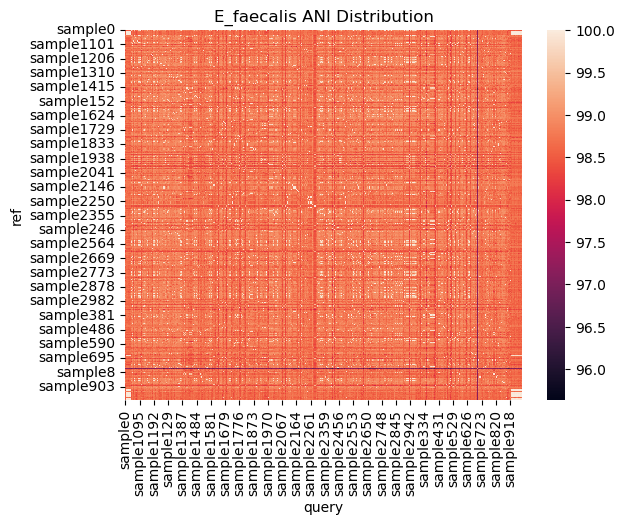

In [106]:
sns.heatmap(new_skani_matrix)
plt.title(f"{species} ANI Distribution")

VISUALIZE ANI DISTRIBUTION - VIOLINPLOT

In [107]:
melted_df = pd.melt(skani_matrix, id_vars=['Tool'], value_vars=['ANI', 'aligned_bases1'], var_name='Type', value_name='Value')
melted_df

,Tool,Type,Value
0,skANI,ANI,100.000000
1,skANI,ANI,98.490000
2,skANI,ANI,98.950000
3,skANI,ANI,98.770000
4,skANI,ANI,98.590000
...,...,...,...
9039037,skANI,aligned_bases1,82.560500
9039038,skANI,aligned_bases1,86.304498
9039039,skANI,aligned_bases1,100.000000
9039040,skANI,aligned_bases1,86.134884


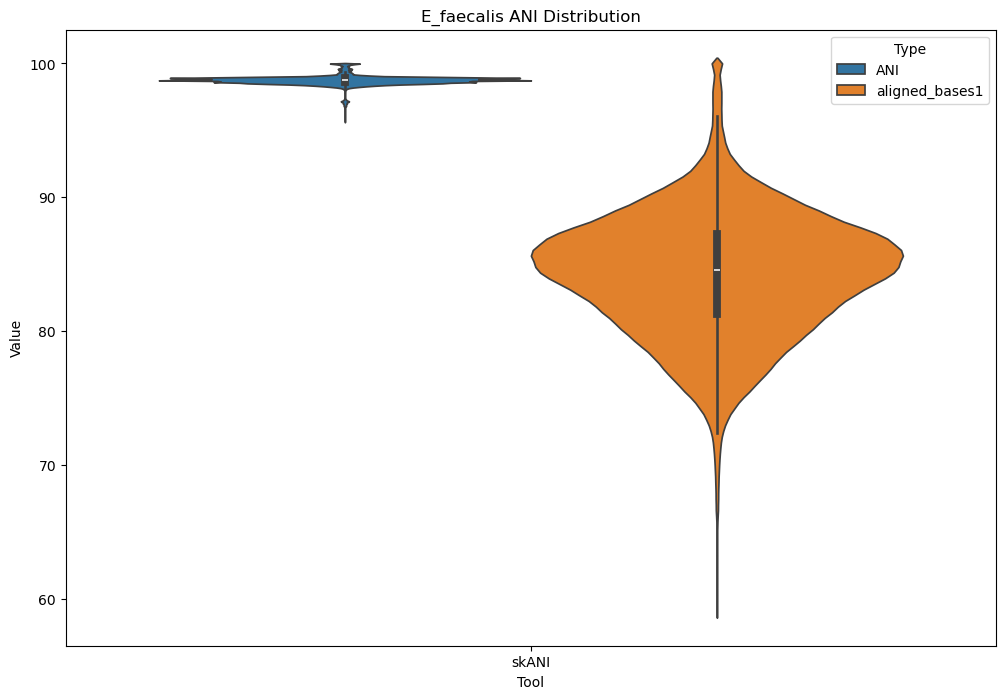

In [108]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=melted_df, x='Tool', y='Value', hue='Type')
plt.title(f'{species} ANI Distribution')
plt.show()

In [109]:
filtered_melted_df = melted_df[melted_df['Type'] == 'ANI']
filtered_melted_df

,Tool,Type,Value
0,skANI,ANI,100.00
1,skANI,ANI,98.49
2,skANI,ANI,98.95
3,skANI,ANI,98.77
4,skANI,ANI,98.59
...,...,...,...
4519516,skANI,ANI,97.13
4519517,skANI,ANI,98.42
4519518,skANI,ANI,100.00
4519519,skANI,ANI,97.13


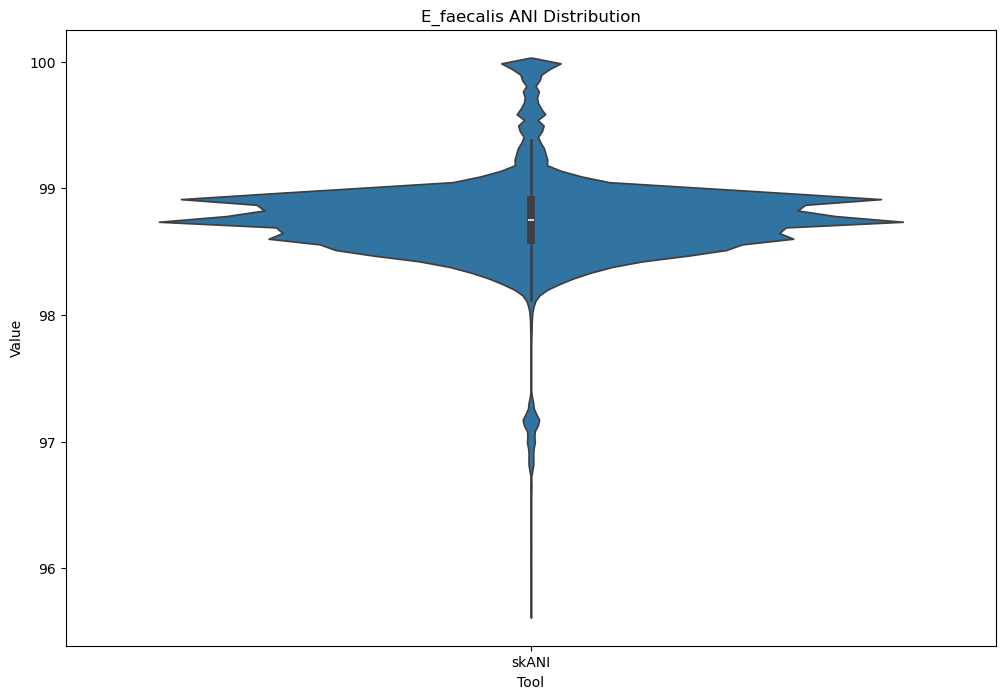

In [110]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=filtered_melted_df, x='Tool', y='Value')
plt.title(f'{species} ANI Distribution')
plt.show()

FILTER OUT HIGHLY DIVERGENT SAMPLES

In [111]:
dissimilarity_matrix = 100 - new_skani_matrix

if (dissimilarity_matrix < 0).any().any():
    raise ValueError("skANI distance matrix contains negative values")

In [112]:
# Z = linkage(dissimilarity_matrix, method='average')

# def cluster_heatmaps(df, Z, num_clusters):
#     clusters = fcluster(Z, t=num_clusters, criterion='distance')
    
#     df['cluster'] = clusters
    
#     for cluster_num in range(1, num_clusters + 1):
#         cluster_samples = df.index[df['cluster'] == cluster_num]
        
#         submatrix = df.loc[cluster_samples, cluster_samples]
        
#         print(len(df['cluster'].unique()))
#         print(submatrix.min())

#         plt.figure(figsize=(6, 5))
#         sns.heatmap(submatrix, cbar=True)
#         plt.title(f"Heatmap for Cluster {cluster_num}")
#         plt.show()

# num_clusters = 3

# cluster_heatmaps(new_skani_matrix, Z, num_clusters)

In [113]:
def cluster_heatmaps(df, max_dist, linkage):
    clustering = AgglomerativeClustering(
        metric='precomputed', # will not recalculate distances
        linkage=linkage, # interested to see other linkages
        distance_threshold=max_dist,
        n_clusters=None
    )
    
    clusters = clustering.fit_predict(df) # assigns samples to clusters

    unique_clusters = np.unique(clusters)
    print(f"{linkage} linkage # clusters: {len(unique_clusters)}")

    cluster_divergence_list = []

    for cluster_num in unique_clusters:
        cluster_samples = np.where(clusters == cluster_num)[0]
        submatrix = df.iloc[cluster_samples, cluster_samples]
        
        max_divergence = submatrix.max().max()
        # print(f"cluster {cluster_num} max divergence: {max_divergence}")
        
        cluster_divergence_list.append({'cluster': cluster_num, 'max_divergence': max_divergence})
    
    divergence_df = pd.DataFrame(cluster_divergence_list)
    
    return clusters, divergence_df
        
        # plt.figure(figsize=(6, 5))
        # sns.heatmap(submatrix, cbar=True)
        # plt.title(f"Heatmap for Cluster {cluster_num + 1}")
        # plt.show()

IQTREE CLUSTERS

In [114]:
# def get_cluster_matrix(df, Z, num_clusters, cluster_num):
#     clusters = fcluster(Z, t=num_clusters, criterion='maxclust')
#     df['cluster'] = clusters
    
#     cluster_samples = df.index[df['cluster'] == cluster_num]
#     submatrix = df.loc[cluster_samples, cluster_samples]
    
#     return submatrix

# get_cluster_matrix(new_skani_matrix, Z, 3, 2)

In [115]:
# threshold = np.percentile(new_skani_matrix.values, 97.5)
# divergent_samples = new_skani_matrix[(new_skani_matrix > threshold) | (new_skani_matrix < -threshold)].stack().reset_index()

# divergent_samples.columns = ['Row_Sample', 'Column_Sample', 'Value']

# print(divergent_samples)

In [116]:
def create_clusters(samples_dict, iqtree_matrix, max_dist):
    # print(f"Clusters for skANI with {linkage} linkage at t = {max_dist}:")
    for cluster_id in iqtree_matrix['cluster'].unique():
        samples_in_cluster = iqtree_matrix[iqtree_matrix['cluster'] == cluster_id]['Ref_file'].values
        samples_dict[cluster_id].extend(samples_in_cluster)
        
        # print(f"Cluster {cluster_id}: {samples_in_cluster}")

In [117]:
def assign_cluster_colours(iqtree_matrix):
    unique_clusters = iqtree_matrix['cluster'].unique()
    palette = sns.color_palette(None, len(unique_clusters))
    cluster_color_map = {cluster: f'rgba({color[0]*255:.2f},{color[1]*255:.2f},{color[2]*255:.2f},1.0)' 
                         for cluster, color in zip(unique_clusters, palette)}
    iqtree_matrix['colour'] = iqtree_matrix['cluster'].map(cluster_color_map)

In [118]:
def write_treefile(directory, linkage, iqtree_matrix):
    with open(f'{directory}iqtree.skani.renamed.treefile.annot.ahc_{linkage}.txt', 'w') as f:
        f.write("\n")
        f.write("        DATASET_COLORSTRIP\n\n")
        f.write("        SEPARATOR SPACE\n")
        f.write(f"        DATASET_LABEL ahc_{linkage}\n")
        f.write("        COLOR #ff0000\n\n")
        f.write("        COLOR_BRANCHES 0\n\n")
        f.write("        DATA\n\n")
        
        for _, row in iqtree_matrix.iterrows():
            genome_id = row['Ref_file']
            colour = row['colour']
            cluster = row['cluster']
            f.write(f"{genome_id} {colour} {cluster}\n")

    print("File writing completed")

In [ ]:
def process_linkages(linkages, dissimilarity_matrix, skani_matrix, max_dist, species):
    all_clusters_samples_dict = defaultdict(list)

    for linkage in linkages:
        cluster_assignments, max_divergence_df = cluster_heatmaps(dissimilarity_matrix, max_dist, linkage)

        to_merge = pd.DataFrame({'index': dissimilarity_matrix.index, 'cluster': cluster_assignments})
        
        merged_matrix = pd.merge(skani_matrix, to_merge, left_on='ref', right_on='index', how='left')
        iqtree_matrix = merged_matrix[['Ref_file', 'cluster']].drop_duplicates().reset_index(drop=True)

        create_clusters(all_clusters_samples_dict, iqtree_matrix, max_dist)

        assign_cluster_colours(iqtree_matrix)

        directory = f'/home/ubuntu/wdir/PopGenStats_Project/data/{species}/tree/'
        os.makedirs(directory, exist_ok=True)

        write_treefile(directory, linkage, iqtree_matrix)

    return all_clusters_samples_dict

In [120]:
max_dist = 1
linkages = ['single', 'average', 'complete']

process_linkages(linkages, dissimilarity_matrix, skani_matrix, max_dist, species)

single linkage # clusters: 13
File writing completed
average linkage # clusters: 92
File writing completed
complete linkage # clusters: 158
File writing completed


defaultdict(list,
            {np.int64(0): ['GCA_000205205.1',
              'GCA_000210115.1',
              'GCA_000499025.1',
              'GCA_000505585.1',
              'GCA_000508705.1',
              'GCA_000696265.1',
              'GCA_000712065.1',
              'GCA_001913975.1',
              'GCA_001913995.1',
              'GCA_002006035.1',
              'GCA_002110435.1',
              'GCA_002324945.1',
              'GCA_002390985.1',
              'GCA_002398665.1',
              'GCA_002417225.1',
              'GCA_002419775.1',
              'GCA_002419925.1',
              'GCA_002421205.1',
              'GCA_002431525.1',
              'GCA_002439425.1',
              'GCA_002484045.1',
              'GCA_002501355.1',
              'GCA_003075115.1',
              'GCA_003075125.1',
              'GCA_003075155.1',
              'GCA_003075175.1',
              'GCA_003449815.1',
              'GCA_003962415.1',
              'GCA_003962575.1',
            

CLUSTERING

In [121]:
def get_clustered_matrix(distance_matrix, cluster_function, threshold, criterion, kwargs={}):
    
    a = np.array(distance_matrix)
    a = a[np.triu_indices_from(a, k=1)]
    
    try:
        clustering = cluster_function(a, metric=None, ** kwargs)
    except TypeError:
        clustering = cluster_function(a, ** kwargs)

    d = dict(zip(distance_matrix.index, fcluster(clustering, threshold, criterion)))
    order = sorted(d, key=lambda n: d.get(n))
    
    nframe = distance_matrix.copy()
    nframe = nframe[order]
    return nframe.reindex(order), d

In [122]:
def get_clusters_stats(res):
    matrix, clustering = res
    nclusters = len(set(clustering.values()))

    matrix = matrix.melt(ignore_index=False, value_name='distance').reset_index()
    matrix['ss1c'] = matrix['ref'].apply(lambda key: clustering[key])
    matrix['ss2c'] = matrix['query'].apply(lambda key: clustering[key])

    smatrix = matrix[matrix['ref'] != matrix['query']]
    same_smatrix = smatrix[smatrix['ss1c'] == smatrix['ss2c']]
    intra_sim = same_smatrix.groupby('ss1c')['distance'].describe().reset_index()

    notsame_smatrix = smatrix[smatrix['ss1c'] != smatrix['ss2c']]
    inter_sim = notsame_smatrix.groupby(['ss1c', 'ss2c'])['distance'].describe().reset_index()

    return nclusters, intra_sim, inter_sim

In [123]:
# matrices = {
#     # 'mummer': new_mummer_matrix,
#     'skani': new_skani_matrix
#     # 'parsnp': new_parsnp_matrix
# }

# d = {
#     'single_distance_1': (single, 1, 'distance', {}),
#     'complete_distance_1': (complete, 1, 'distance', {}),
#     'avg_distance_1': (average, 1, 'distance', {}),
#     'single_distance_96': (single, 96.5, 'distance', {}),
#     'avg_distance_98': (average, 98.5, 'distance', {})
#     # 'avg_distance_50': (average, 50, 'distance', {}),
#     # 'avg_distance_75': (average, 75, 'distance', {}),
#     # 'avg_distance_80': (average, 80, 'distance', {}),
#     # 'avg_distance_85': (average, 85, 'distance', {})
#     # 'linkage_complete_distance_10': (linkage, 10, 'distance', {'method': 'complete'}),
#     # 'linkage_complete_distance_15': (linkage, 15, 'distance', {'method': 'complete'}),
#     # 'linkage_complete_distance_20': (linkage, 20, 'distance', {'method': 'complete'}),
#     # 'linkage_complete_distance_25': (linkage, 25, 'distance', {'method': 'complete'})
# }

# allres_ncluster = []
# allres_intra = []
# allres_inter = []

# for matrix_name, matrix in matrices.items():
#     for method_name, values in d.items():
#         res = get_clustered_matrix(matrix, *values)
#         stats = get_clusters_stats(res)
#         ncluster, intra, inter = stats
        
#         ncluster = len(set(res[1].values()))
#         allres_ncluster.append({
#             'method': method_name,
#             'nclusters': ncluster,
#             'matrix': matrix_name
#         })

#         intra['method'] = method_name
#         intra['matrix'] = matrix_name
#         allres_intra.append(intra)
        
#         inter['method'] = method_name
#         inter['matrix'] = matrix_name
#         allres_inter.append(inter)

#         colors = list(sns.color_palette())
#         colors = [colors[value % len(colors)] for value in sorted(res[1].values())]

#         sns.clustermap(res[0], row_cluster=False, col_cluster=False, row_colors=colors, col_colors=colors)
#         plt.title(method_name)
    
# allres_ncluster = pd.DataFrame(allres_ncluster)
# allres_inter = pd.concat(allres_inter)
# allres_intra = pd.concat(allres_intra)

# allres_intra['max'].max(), allres_inter['min'].min()

THRESHOLD VS # CLUSTERS

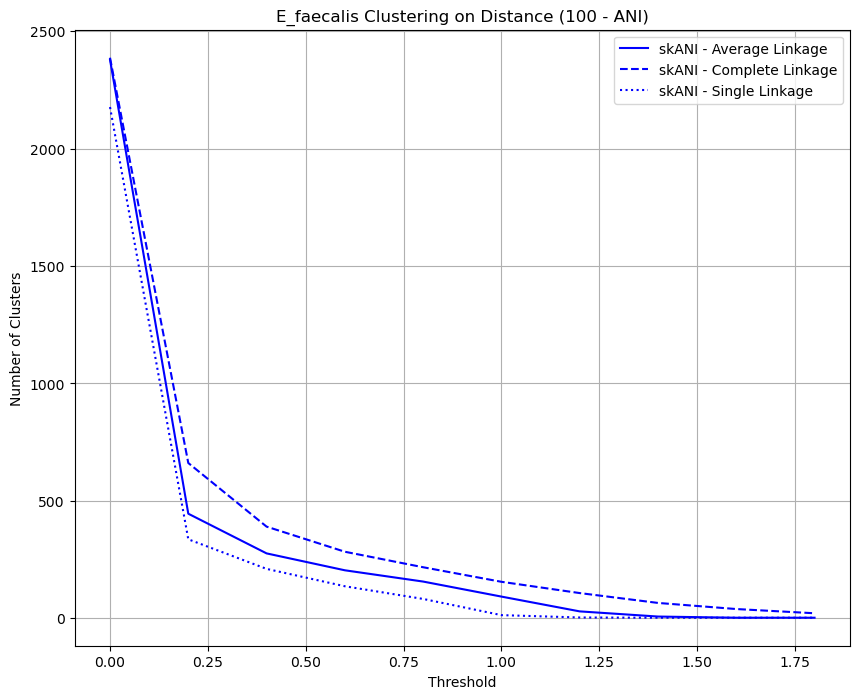

In [124]:
threshold_values = [i / 10 for i in range(0, 20, 2)]

skani_results_avg = {}
skani_results_compl = {}
skani_results_single = {}

for threshold in threshold_values:
    # average
    skani_res_a = get_clustered_matrix(dissimilarity_matrix, average, threshold, 'distance')
    skani_clusters_a = skani_res_a[1]
    num_skani_clusters_a = len(set(skani_clusters_a.values()))
    skani_results_avg[threshold] = num_skani_clusters_a

    # complete
    skani_res_c = get_clustered_matrix(dissimilarity_matrix, complete, threshold, 'distance')
    skani_clusters_c = skani_res_c[1]
    num_skani_clusters_c = len(set(skani_clusters_c.values()))
    skani_results_compl[threshold] = num_skani_clusters_c

    # single
    skani_res_s = get_clustered_matrix(dissimilarity_matrix, single, threshold, 'distance')
    skani_clusters_s = skani_res_s[1]
    num_skani_clusters_s = len(set(skani_clusters_s.values()))
    skani_results_single[threshold] = num_skani_clusters_s

plt.figure(figsize=(10, 8))

plt.plot(list(skani_results_avg.keys()), list(skani_results_avg.values()), 'b-', label='skANI - Average Linkage')
plt.plot(list(skani_results_compl.keys()), list(skani_results_compl.values()), 'b--', label='skANI - Complete Linkage')
plt.plot(list(skani_results_single.keys()), list(skani_results_single.values()), 'b:', label='skANI - Single Linkage')

plt.title(f'{species} Clustering on Distance (100 - ANI)')
plt.xlabel('Threshold')
plt.ylabel('Number of Clusters')
plt.grid(True)
plt.legend(loc='best')
plt.show()

In [125]:
def get_y_for_x(x_value, results_dict):
    x_points = list(results_dict.keys())
    y_points = list(results_dict.values())
    
    y_interpolated = np.interp(x_value, x_points, y_points)
    return y_interpolated

x_value = 1

y_skani_avg = get_y_for_x(x_value, skani_results_avg)
y_skani_compl = get_y_for_x(x_value, skani_results_compl)
y_skani_single = get_y_for_x(x_value, skani_results_single)

print(f"Y values for x = {x_value}:")
print(f"skANI - Average Linkage: {y_skani_avg}")
print(f"skANI - Complete Linkage: {y_skani_compl}")
print(f"skANI - Single Linkage: {y_skani_single}")

Y values for x = 1:
skANI - Average Linkage: 92.0
skANI - Complete Linkage: 155.0
skANI - Single Linkage: 13.0


In [126]:
def get_clusters_for_linkage(distance_matrix, linkage_function, threshold, tool_name, linkage_name):
    res = get_clustered_matrix(distance_matrix, linkage_function, threshold, 'distance')

    clusters = res[1]

    clusters_samples_dict = defaultdict(list)
    for sample, cluster_id in clusters.items():
        clusters_samples_dict[cluster_id].append(sample)

    # print(f"\nClusters for {tool_name} with {linkage_name} linkage at threshold {threshold}:")
    for cluster_id, samples in clusters_samples_dict.items():
        # print(f"Cluster {cluster_id}:")
        # for sample in samples:
        #     print(f"  {sample}")
        samples_array = np.array(samples)
        # print(f"Cluster {cluster_id}: {samples_array}")
    return clusters_samples_dict

tools = [
    (dissimilarity_matrix, 'skANI', [average, 'Average Linkage'], [complete, 'Complete Linkage'], [single, 'Single Linkage'])
]

for distance_matrix, tool_name, *linkages in tools:
    for linkage_function, linkage_name in linkages:
        get_clusters_for_linkage(distance_matrix, linkage_function, x_value, tool_name, linkage_name)